# DC-GAN - Type3 - Diabetic Retinopathy

In [1]:
import os
import sys
import glob
import json
import random
import argparse
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ[ "CUDA_VISIBLE_DEVICES" ]="4"

In [4]:
seed = 963
random.seed(seed)
torch.manual_seed(seed)

### Hyperparamters

In [5]:
params = {
    "bsize" : 8, # Batch size during training.
    'imsize' : 360, # Spatial size of training images.
    'nc' : 3, # Number of channles in the training images.
    'nz' : 100, # Size of the Z latent vector.
    'ngf' : 32, # Size of feature maps in the generator.
    'ndf' : 64, # Size of features maps in the discriminator.
    'nepochs' : 250, # Number of training epochs.
    'lr' : 0.0002, # Learning rate for optimizers
    'beta1' : 0.5, # Beta1 hyperparam for Adam optimizer
    'save_epoch' : 5 # Save step.
}

### Data Loader

In [6]:
root = './dataset/dcgan_v3/train3'

def load_dataset(params):
    # Data proprecessing.
    
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    dataset = dset.ImageFolder(root=root, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True, num_workers= 16)

    return dataloader

In [7]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### Training Samples

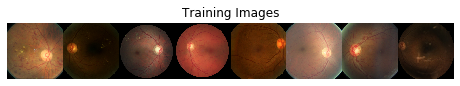

In [8]:
dataloader = load_dataset(params)

sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
   sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Discriminator, Generator & Parameter Definitions

In [9]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8*2,
            kernel_size=5, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8*2)
        
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8*2, params['ngf']*4*2,
            5, 3, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4*2)

        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4*2, params['ngf']*2*2,
            5, 3, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2*2)

        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2*2, params['ngf']*2,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf']*2)

        self.tconv5 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ngf'])

        self.tconv7 = nn.ConvTranspose2d(params['ngf'], params['nc'],
            4, 2, 1, bias=False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv7(x))
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            5, 3, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        self.conv5 = nn.Conv2d(params['ndf']*8, params['ndf']*16,
            5, 3, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ndf']*16)

        self.conv6 = nn.Conv2d(params['ndf']*16, 1, 5, 1, 0, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.sigmoid(self.conv6(x))

        return x

In [12]:
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv7): ConvTranspose2d(32, 3, kernel_size=(4, 4), 

In [13]:
netD = Discriminator(params).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [16]:
# Stores generated images as training progresses.
img_list = []

# Stores generator losses during training.
G_losses = []

# Stores discriminator losses during training.
D_losses = []

iters = 0

## Training

In [17]:
print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    batches_done = 0
    for i, data in enumerate(dataloader, 0):
        batches_done +=1
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        netD.zero_grad()
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label  )
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, params['nepochs'], i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type3/model_epoch_{}.pth'.format(epoch+1))

Starting Training Loop...
-------------------------


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/250][1/110]	Loss_D: 1.4335	Loss_G: 16.8390	D(x): 0.4751	D(G(z)): 0.4863 / 0.0000
[1/250][101/110]	Loss_D: 0.0011	Loss_G: 14.7775	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[2/250][1/110]	Loss_D: 0.0185	Loss_G: 7.2214	D(x): 1.0000	D(G(z)): 0.0174 / 0.0037
[2/250][101/110]	Loss_D: 0.0197	Loss_G: 6.0872	D(x): 0.9983	D(G(z)): 0.0178 / 0.0053
[3/250][1/110]	Loss_D: 0.1549	Loss_G: 3.6645	D(x): 0.9938	D(G(z)): 0.1348 / 0.0366
[3/250][101/110]	Loss_D: 0.1198	Loss_G: 4.5448	D(x): 0.9192	D(G(z)): 0.0260 / 0.0165
[4/250][1/110]	Loss_D: 1.0043	Loss_G: 2.1596	D(x): 0.6406	D(G(z)): 0.2402 / 0.1624
[4/250][101/110]	Loss_D: 0.7922	Loss_G: 2.3726	D(x): 0.6048	D(G(z)): 0.2112 / 0.0965
[5/250][1/110]	Loss_D: 3.7850	Loss_G: 2.6776	D(x): 0.1382	D(G(z)): 0.0060 / 0.1305
[5/250][101/110]	Loss_D: 0.3684	Loss_G: 2.4195	D(x): 0.7269	D(G(z)): 0.0199 / 0.1318
[6/250][1/110]	Loss_D: 2.5162	Loss_G: 3.5840	D(x): 0.1184	D(G(z)): 0.0049 / 0.0434
[6/250][101/110]	Loss_D: 0.7221	Loss_G: 0.9959	D(x): 0.5844	D(G(z)): 0.1079

[49/250][101/110]	Loss_D: 0.0384	Loss_G: 4.6368	D(x): 0.9862	D(G(z)): 0.0235 / 0.0196
[50/250][1/110]	Loss_D: 0.0472	Loss_G: 5.5188	D(x): 0.9674	D(G(z)): 0.0125 / 0.0091
[50/250][101/110]	Loss_D: 0.1406	Loss_G: 5.9094	D(x): 0.9654	D(G(z)): 0.0916 / 0.0048
[51/250][1/110]	Loss_D: 0.0663	Loss_G: 7.4884	D(x): 0.9400	D(G(z)): 0.0020 / 0.0030
[51/250][101/110]	Loss_D: 0.1582	Loss_G: 4.8159	D(x): 0.8993	D(G(z)): 0.0307 / 0.0196
[52/250][1/110]	Loss_D: 1.2179	Loss_G: 11.8150	D(x): 0.9999	D(G(z)): 0.5263 / 0.0000
[52/250][101/110]	Loss_D: 0.1222	Loss_G: 6.4220	D(x): 0.8991	D(G(z)): 0.0116 / 0.0099
[53/250][1/110]	Loss_D: 2.0317	Loss_G: 15.8623	D(x): 0.9994	D(G(z)): 0.5433 / 0.0001
[53/250][101/110]	Loss_D: 0.2316	Loss_G: 4.8715	D(x): 0.9998	D(G(z)): 0.1858 / 0.0134
[54/250][1/110]	Loss_D: 0.1386	Loss_G: 6.8514	D(x): 0.9956	D(G(z)): 0.1150 / 0.0027
[54/250][101/110]	Loss_D: 0.0271	Loss_G: 6.9226	D(x): 0.9775	D(G(z)): 0.0040 / 0.0030
[55/250][1/110]	Loss_D: 0.3385	Loss_G: 7.6920	D(x): 0.8950	D(G

[98/250][1/110]	Loss_D: 0.2981	Loss_G: 12.0255	D(x): 0.9999	D(G(z)): 0.1656 / 0.0000
[98/250][101/110]	Loss_D: 0.0878	Loss_G: 6.3231	D(x): 0.9706	D(G(z)): 0.0506 / 0.0030
[99/250][1/110]	Loss_D: 0.0002	Loss_G: 14.5470	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[99/250][101/110]	Loss_D: 0.2195	Loss_G: 6.8845	D(x): 0.8406	D(G(z)): 0.0019 / 0.0044
[100/250][1/110]	Loss_D: 0.1138	Loss_G: 5.3213	D(x): 0.9998	D(G(z)): 0.0902 / 0.0199
[100/250][101/110]	Loss_D: 0.0499	Loss_G: 4.0273	D(x): 0.9999	D(G(z)): 0.0474 / 0.0631
[101/250][1/110]	Loss_D: 1.2241	Loss_G: 18.4363	D(x): 1.0000	D(G(z)): 0.5049 / 0.0001
[101/250][101/110]	Loss_D: 0.8245	Loss_G: 3.4719	D(x): 0.5734	D(G(z)): 0.0007 / 0.2615
[102/250][1/110]	Loss_D: 0.0008	Loss_G: 9.7508	D(x): 0.9998	D(G(z)): 0.0006 / 0.0005
[102/250][101/110]	Loss_D: 0.0086	Loss_G: 11.1065	D(x): 0.9934	D(G(z)): 0.0019 / 0.0010
[103/250][1/110]	Loss_D: 0.0026	Loss_G: 8.1001	D(x): 0.9993	D(G(z)): 0.0020 / 0.0033
[103/250][101/110]	Loss_D: 0.3271	Loss_G: 4.6399	D(x): 

[145/250][101/110]	Loss_D: 0.0507	Loss_G: 7.0252	D(x): 0.9751	D(G(z)): 0.0225 / 0.0053
[146/250][1/110]	Loss_D: 7.1802	Loss_G: 20.7539	D(x): 1.0000	D(G(z)): 0.8714 / 0.0000
[146/250][101/110]	Loss_D: 0.1839	Loss_G: 2.8984	D(x): 0.9221	D(G(z)): 0.0569 / 0.2273
[147/250][1/110]	Loss_D: 0.0055	Loss_G: 9.3236	D(x): 0.9994	D(G(z)): 0.0048 / 0.0006
[147/250][101/110]	Loss_D: 0.0134	Loss_G: 5.8787	D(x): 0.9970	D(G(z)): 0.0102 / 0.0052
[148/250][1/110]	Loss_D: 0.0039	Loss_G: 8.2231	D(x): 0.9990	D(G(z)): 0.0029 / 0.0010
[148/250][101/110]	Loss_D: 0.0150	Loss_G: 12.5591	D(x): 0.9857	D(G(z)): 0.0000 / 0.0000
[149/250][1/110]	Loss_D: 0.0025	Loss_G: 10.7967	D(x): 0.9990	D(G(z)): 0.0014 / 0.0041
[149/250][101/110]	Loss_D: 0.1479	Loss_G: 4.0119	D(x): 0.8829	D(G(z)): 0.0060 / 0.0292
[150/250][1/110]	Loss_D: 1.6663	Loss_G: 13.3674	D(x): 1.0000	D(G(z)): 0.5293 / 0.0001
[150/250][101/110]	Loss_D: 0.0055	Loss_G: 7.6119	D(x): 0.9973	D(G(z)): 0.0028 / 0.0021
[151/250][1/110]	Loss_D: 0.0178	Loss_G: 11.0565	D

[193/250][1/110]	Loss_D: 0.0228	Loss_G: 6.4956	D(x): 0.9993	D(G(z)): 0.0212 / 0.0035
[193/250][101/110]	Loss_D: 0.0200	Loss_G: 6.9527	D(x): 0.9884	D(G(z)): 0.0078 / 0.0017
[194/250][1/110]	Loss_D: 0.1810	Loss_G: 14.0156	D(x): 1.0000	D(G(z)): 0.0969 / 0.0000
[194/250][101/110]	Loss_D: 0.7980	Loss_G: 22.3902	D(x): 0.9999	D(G(z)): 0.3818 / 0.0000
[195/250][1/110]	Loss_D: 0.0004	Loss_G: 12.0556	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[195/250][101/110]	Loss_D: 0.0147	Loss_G: 7.8066	D(x): 0.9871	D(G(z)): 0.0012 / 0.0025
[196/250][1/110]	Loss_D: 3.1607	Loss_G: 28.2015	D(x): 1.0000	D(G(z)): 0.9170 / 0.0000
[196/250][101/110]	Loss_D: 0.0184	Loss_G: 11.8216	D(x): 0.9841	D(G(z)): 0.0019 / 0.0012
[197/250][1/110]	Loss_D: 0.0360	Loss_G: 5.9263	D(x): 0.9991	D(G(z)): 0.0335 / 0.0059
[197/250][101/110]	Loss_D: 0.2568	Loss_G: 9.4542	D(x): 0.8273	D(G(z)): 0.0001 / 0.0009
[198/250][1/110]	Loss_D: 0.0060	Loss_G: 7.3910	D(x): 0.9952	D(G(z)): 0.0011 / 0.0012
[198/250][101/110]	Loss_D: 0.0150	Loss_G: 10.2213	

[246/250][101/110]	Loss_D: 0.0002	Loss_G: 17.2780	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[247/250][1/110]	Loss_D: 0.0335	Loss_G: 13.2528	D(x): 1.0000	D(G(z)): 0.0315 / 0.0082
[247/250][101/110]	Loss_D: 0.0263	Loss_G: 9.1061	D(x): 0.9764	D(G(z)): 0.0003 / 0.0005
[248/250][1/110]	Loss_D: 0.0037	Loss_G: 7.7091	D(x): 0.9996	D(G(z)): 0.0033 / 0.0016
[248/250][101/110]	Loss_D: 0.4254	Loss_G: 11.2423	D(x): 0.8755	D(G(z)): 0.0054 / 0.0382
[249/250][1/110]	Loss_D: 0.0052	Loss_G: 14.6850	D(x): 1.0000	D(G(z)): 0.0051 / 0.0028
[249/250][101/110]	Loss_D: 0.5937	Loss_G: 22.0202	D(x): 0.6838	D(G(z)): 0.0000 / 0.0000
[250/250][1/110]	Loss_D: 0.0110	Loss_G: 9.1083	D(x): 1.0000	D(G(z)): 0.0108 / 0.0023
[250/250][101/110]	Loss_D: 0.0021	Loss_G: 7.8214	D(x): 1.0000	D(G(z)): 0.0021 / 0.0014


In [18]:
# Final Trained Model.

torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type3/model_final.pth')

In [19]:
with open('model/type3/G_losses_type3.json', 'w') as f:
    json.dump(G_losses, f)

with open('model/type3/D_losses_type3.json', 'w') as f:
    json.dump(D_losses, f)

### Discriminator vs Generator Loss Plot

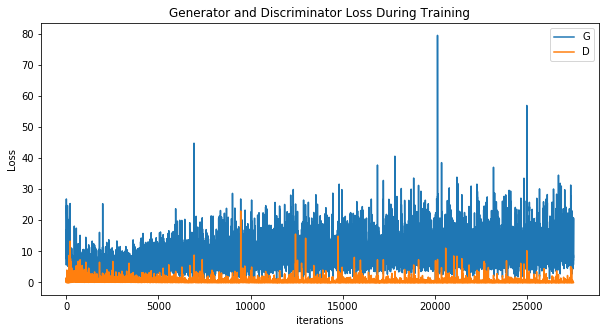

In [20]:
# Plot the Training Losses.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./generated_images/type3/discriminator_generator_loss_plot_type3.png')
plt.show()

## Sample Generation from Trained Model

### Sample from each Epochs

In [21]:
with tqdm(params['nepochs']) as pbar:
    for epoch in range(0,params['nepochs'],5):
        path = f'model/type3/model_epoch_{epoch+1}.pth'
        state_dict = torch.load(path,map_location='cpu')

        device = torch.device("cuda")
        params = state_dict['params']

        netG = Generator(params).to(device)
        netG.load_state_dict(state_dict['generator'])

        for i in range(10):
            noise = torch.randn(1, params['nz'], 1, 1, device=device)

            with torch.no_grad():
                generated_img = netG(noise).detach().cpu()

            image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
            plt.imsave(fname=f'./generated_images/type3/pic_generated_{epoch}_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(5)

250it [01:53,  2.21it/s]


### Samples from Final Epoch

In [22]:
path = f'model/type3/model_final.pth'
state_dict = torch.load(path,map_location='cpu')
device = torch.device("cuda")
params = state_dict['params']

netG = Generator(params).to(device)
netG.load_state_dict(state_dict['generator'])

with tqdm(1000) as pbar:
    for i in range(1000):
        noise = torch.randn(1, params['nz'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(noise).detach().cpu()
        
        image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
        plt.imsave(fname=f'./generated_images/3_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(1)

1000it [03:10,  5.26it/s]


### Learning Transitions across Epochs (Animation)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


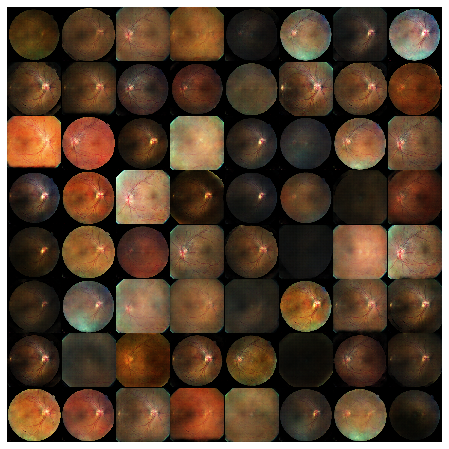

In [23]:
# Animation showing the overall improvements of the generator during the training.

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type3/fundus_type3.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


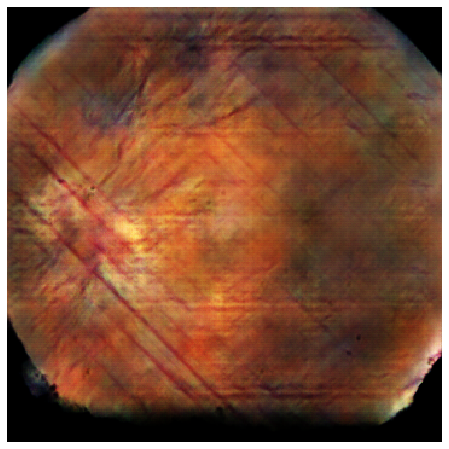

In [24]:
# Animation showing the improvements of the generator for across epoch from generated samples.

img_list = map(plt.imread, sorted(glob.glob('./generated_images/type3/*10.png')))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type3/fundus_type3_1.gif', dpi=80, writer='imagemagick')